In [ ]:

# Instalação (Colab) — rode uma vez
#!pip install -q datasets transformers scikit-learn torch matplotlib peft accelerate


# Bilbiotecas

In [1]:

import os, time, random
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
)
from sklearn.metrics import log_loss as sk_log_loss

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    TrainerCallback,
    EarlyStoppingCallback,
)

from peft import LoraConfig, TaskType, get_peft_model


# Configurações

In [2]:

# ---------------------------
# Configurações globais
# ---------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# Multi-seeds: para rigor extra use 3 seeds (vai demorar mais)
SEEDS = [42]  # ex: [42, 7, 123]

DATASET_NAME = "cornell-movie-review-data/rotten_tomatoes"  # binário

# Baselines
N_EPOCHS_TFIDF = 50
RUN_NB_BASELINE = True

RUN_LSTM_BASELINE = True
N_EPOCHS_LSTM = 50
BATCH_SIZE_LSTM = 64
MAX_LEN_LSTM = 64
EMBED_DIM = 128
HIDDEN_DIM = 128

# Transformers
BASE_TRANSFORMER = "roberta-base"
RUN_TRANSFORMER_BASE = True
RUN_TRANSFORMER_LORA = True

# Ablações simples (opcionais)
MAX_LENGTHS = [128]            # ex: [64, 128, 256]
FREEZE_N_LAYERS_LIST = [0]     # ex: [0, 2, 4]

N_EPOCHS_TRANSFORMER = 50
TRAIN_BATCH = 16
EVAL_BATCH = 32

# Avaliar teste a cada época (curva de teste); aumenta custo
EVAL_TEST_EACH_EPOCH = True


Device: cuda


In [3]:

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [4]:

dataset = load_dataset(DATASET_NAME)
print(dataset)

def to_df(split):
    return pd.DataFrame({"text": [x["text"] for x in split],
                         "label": [x["label"] for x in split]})

df_train = to_df(dataset["train"])
df_val   = to_df(dataset["validation"])
df_test  = to_df(dataset["test"])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})


# Baselines

## Majority class

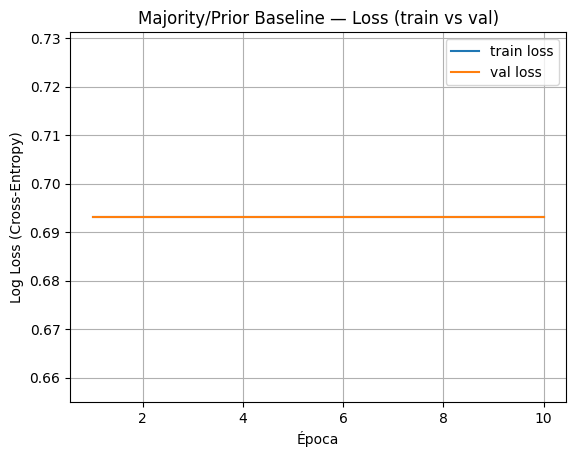

Majority class (hard):
  Train acc: 0.5
  Val   acc: 0.5
Prior (soft) log loss:
  Train loss: 0.6931471805599453
  Val   loss: 0.6931471805599453


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss

def majority_baseline_with_loss_curve(df_train, df_val, n_epochs=10):
    y_tr = df_train["label"].to_numpy()
    y_va = df_val["label"].to_numpy()

    # Probabilidades fixas = distribuição do treino (baseline "prior")
    p1 = y_tr.mean()          # P(y=1)
    p0 = 1.0 - p1             # P(y=0)

    # Predição "majority class" (hard)
    yhat_tr = np.full_like(y_tr, 1 if p1 >= 0.5 else 0)
    yhat_va = np.full_like(y_va, 1 if p1 >= 0.5 else 0)

    # Para loss: usamos probs fixas (não hard 0/1), pra log_loss ficar finito
    proba_tr = np.tile([p0, p1], (len(y_tr), 1))
    proba_va = np.tile([p0, p1], (len(y_va), 1))

    train_loss = log_loss(y_tr, proba_tr, labels=[0, 1])
    val_loss   = log_loss(y_va, proba_va, labels=[0, 1])

    # Curvas (constantes)
    loss_curve_train = [train_loss] * n_epochs
    loss_curve_val   = [val_loss] * n_epochs

    # Plot
    plt.figure()
    plt.plot(range(1, n_epochs + 1), loss_curve_train, label="train loss")
    plt.plot(range(1, n_epochs + 1), loss_curve_val, label="val loss")
    plt.title("Majority/Prior Baseline — Loss (train vs val)")
    plt.xlabel("Época")
    plt.ylabel("Log Loss (Cross-Entropy)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Métricas resumidas
    print("Majority class (hard):")
    print("  Train acc:", accuracy_score(y_tr, yhat_tr))
    print("  Val   acc:", accuracy_score(y_va, yhat_va))
    print("Prior (soft) log loss:")
    print("  Train loss:", train_loss)
    print("  Val   loss:", val_loss)

# Exemplo de uso:
majority_baseline_with_loss_curve(df_train, df_val, n_epochs=10)

OBS: Não melhora com o nº de épocas e ela sempre prevê uma única classe, além de não aprender. Sua accuracy fica por volta dos 50%

## TD + IDF LogReg (SGD)

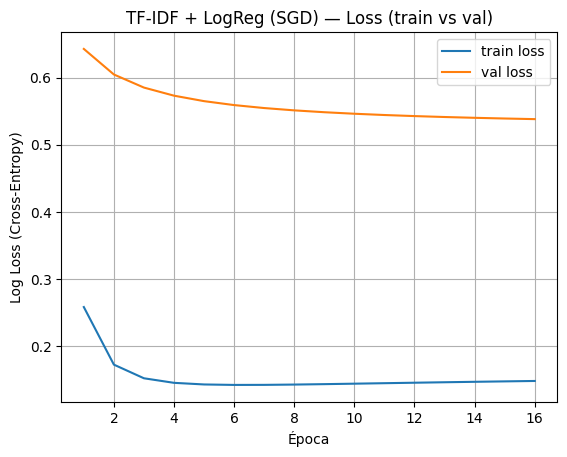

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (
    log_loss, accuracy_score, precision_recall_fscore_support, f1_score
)

def tfidf_logreg_sgd_loss_curve_improved(
    df_train, df_val, df_test,
    n_epochs=50,
    patience=8,
    max_features=80000,
    ngram_range=(1,3), # Updated to the best performing value
    stop_words="english",
    sublinear_tf=True,
    min_df=2,
    max_df=0.95,
    analyzer="word",
    alpha=1e-5, # Updated to the best performing value
    penalty="l2",
    l1_ratio=0.15,
    learning_rate="optimal",
    eta0=0.0,
    average=True,
    target_metric="f1_macro"
):
    # Dados
    Xtr_text = df_train["text"].astype(str).values
    y_tr = df_train["label"].astype(int).values

    Xva_text = df_val["text"].astype(str).values
    y_va = df_val["label"].astype(int).values

    Xte_text = df_test["text"].astype(str).values
    y_te = df_test["label"].astype(int).values

    # TF-IDF melhorado
    vec = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        stop_words=stop_words,
        sublinear_tf=sublinear_tf,
        min_df=min_df,
        max_df=max_df,
        analyzer=analyzer,
        norm="l2",
    )
    X_tr = vec.fit_transform(Xtr_text)
    X_va = vec.transform(Xva_text)
    X_te = vec.transform(Xte_text)

    # SGD "LogReg" melhorado
    classes = np.array([0, 1], dtype=int)
    clf = SGDClassifier(
        loss="log_loss",
        penalty=penalty,
        alpha=alpha,
        l1_ratio=(l1_ratio if penalty == "elasticnet" else 0.0),
        learning_rate=learning_rate,
        eta0=eta0,
        average=average,
        max_iter=1,
        tol=None,
        random_state=42
    )

    # Históricos
    train_losses, val_losses, test_losses = [], [], []
    train_accs, val_accs, test_accs = [], [], []
    train_f1m, val_f1m, test_f1m = [], [], []

    best_val = -1.0
    best_state = None
    bad = 0

    for epoch in range(1, n_epochs + 1):
        clf.partial_fit(X_tr, y_tr, classes=classes)

        # Probabilidades (para log loss)
        p_tr = clf.predict_proba(X_tr)
        p_va = clf.predict_proba(X_va)
        p_te = clf.predict_proba(X_te)

        # Loss
        tr_loss = log_loss(y_tr, p_tr, labels=classes)
        va_loss = log_loss(y_va, p_va, labels=classes)
        te_loss = log_loss(y_te, p_te, labels=classes)

        train_losses.append(tr_loss)
        val_losses.append(va_loss)
        test_losses.append(te_loss)

        # Predições (threshold padrão 0.5)
        yhat_tr = (p_tr[:,1] >= 0.5).astype(int)
        yhat_va = (p_va[:,1] >= 0.5).astype(int)
        yhat_te = (p_te[:,1] >= 0.5).astype(int)

        train_accs.append(accuracy_score(y_tr, yhat_tr))
        val_accs.append(accuracy_score(y_va, yhat_va))
        test_accs.append(accuracy_score(y_te, yhat_te))

        # F1 macro (para acompanhar)
        train_f1m.append(f1_score(y_tr, yhat_tr, average="macro", zero_division=0))
        val_f1m.append(f1_score(y_va, yhat_va, average="macro", zero_division=0))
        test_f1m.append(f1_score(y_te, yhat_te, average="macro", zero_division=0))

        # Early stopping manual pela métrica alvo no VAL
        if target_metric == "f1_pos1":
            cur = f1_score(y_va, yhat_va, pos_label=1, zero_division=0)
        else:
            cur = f1_score(y_va, yhat_va, average="macro", zero_division=0)

        if cur > best_val + 1e-6:
            best_val = float(cur)
            best_state = clf
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    # Plot Loss (train vs val)
    plt.figure()
    plt.plot(range(1, len(train_losses)+1), train_losses, label="train loss")
    plt.plot(range(1, len(val_losses)+1),   val_losses,   label="val loss")
    plt.title("TF-IDF + LogReg (SGD) — Loss (train vs val)")
    plt.xlabel("Época")
    plt.ylabel("Log Loss (Cross-Entropy)")
    plt.grid(True)
    plt.legend()
    plt.show()

    history = {
        "loss": {"train": train_losses, "val": val_losses, "test": test_losses},
        "acc":  {"train": train_accs,   "val": val_accs,   "test": test_accs},
        "f1_macro": {"train": train_f1m, "val": val_f1m, "test": test_f1m},
    }

    return clf, vec, history

    clf_sgd, vec_tfidf, hist_sgd = tfidf_logreg_sgd_loss_curve_improved(
    df_train, df_val, df_test,
    n_epochs=30
)

#Exemplo de uso:
clf_sgd, vec_tfidf, hist_sgd = tfidf_logreg_sgd_loss_curve_improved(
    df_train, df_val, df_test,
    n_epochs=60
)

## BiLSTM

Calling bilstm_loss_curve with updated parameters...
Epoch 1/50 - Train Loss: 0.6464, Val Loss: 0.6233, Val Acc: 0.6520, Val F1: 0.6373
Epoch 2/50 - Train Loss: 0.5537, Val Loss: 0.5965, Val Acc: 0.6585, Val F1: 0.6035
Epoch 3/50 - Train Loss: 0.4836, Val Loss: 0.5675, Val Acc: 0.6951, Val F1: 0.7121
Epoch 4/50 - Train Loss: 0.4164, Val Loss: 0.5565, Val Acc: 0.6961, Val F1: 0.7017
Epoch 5/50 - Train Loss: 0.3582, Val Loss: 0.5482, Val Acc: 0.6970, Val F1: 0.6885
Epoch 6/50 - Train Loss: 0.3159, Val Loss: 0.5451, Val Acc: 0.7054, Val F1: 0.7004
Epoch 7/50 - Train Loss: 0.2742, Val Loss: 0.6115, Val Acc: 0.6923, Val F1: 0.7376
Epoch 8/50 - Train Loss: 0.2462, Val Loss: 0.5613, Val Acc: 0.7064, Val F1: 0.7028
Epoch 9/50 - Train Loss: 0.2231, Val Loss: 0.5653, Val Acc: 0.7026, Val F1: 0.6674
Epoch 10/50 - Train Loss: 0.2085, Val Loss: 0.5586, Val Acc: 0.7083, Val F1: 0.6843
Epoch 11/50 - Train Loss: 0.1980, Val Loss: 0.5622, Val Acc: 0.7158, Val F1: 0.7050
Epoch 12/50 - Train Loss: 0.1957

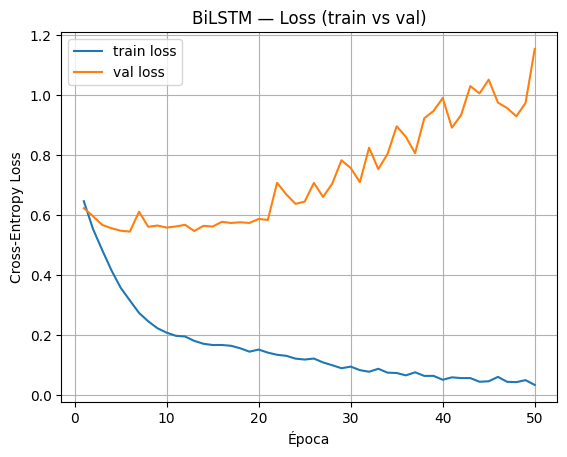

In [7]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F # Adicionado para Global Max Pooling

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score

# DEVICE e set_seed já definidos globalmente

# --------- utilitários de texto/vocabulário ----------
def simple_tokenize(text: str):
    return text.lower().strip().split()

def build_vocab(texts, min_freq=2):
    from collections import Counter
    c = Counter()
    for t in texts:
        c.update(simple_tokenize(str(t)))
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for tok, freq in c.items():
        if freq >= min_freq:
            vocab[tok] = len(vocab)
    return vocab

def encode_text(text: str, vocab, max_len):
    ids = [vocab.get(tok, vocab["<UNK>"]) for tok in simple_tokenize(str(text))][:max_len]
    if len(ids) < max_len:
        ids += [vocab["<PAD>"]] * (max_len - len(ids))
    return ids

# --------- dataset ----------
class LSTMDataset(Dataset):
    def __init__(self, df, vocab, max_len):
        self.texts = df["text"].astype(str).tolist()
        self.labels = df["label"].astype(int).tolist()
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        ids = encode_text(self.texts[idx], self.vocab, self.max_len)
        return torch.tensor(ids, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

# --------- modelo (IMPROVED) ----------
class BiLSTMClassifier(nn.Module): # Renomeado de BiLSTMClassifier_Improved
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes=2):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        e = self.emb(x)              # (B, T, E)
        o, _ = self.lstm(e)          # (B, T, 2H)

        # Global Max Pooling: Take the maximum value across all time steps for each feature
        # Output of LSTM: (batch_size, seq_len, 2 * hidden_dim)
        # Max pooling over seq_len dimension: (batch_size, 2 * hidden_dim)
        pooled = F.max_pool1d(o.permute(0, 2, 1), o.size(1)).squeeze(2)

        return self.fc(pooled)       # (B, C)

# --------- treino + avaliação ----------
@torch.no_grad()
def eval_epoch(model, loader, criterion):
    model.eval()
    losses, y_true, y_pred = [], [], []
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = criterion(logits, y)
        losses.append(loss.item())
        preds = logits.argmax(dim=-1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    # Calculate precision, recall, f1 for the evaluation set
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)

    return float(np.mean(losses)), accuracy_score(y_true, y_pred), float(precision), float(recall), float(f1)

def bilstm_loss_curve( # Renomeado de bilstm_loss_curve_improved
    df_train, df_val, n_epochs=15, batch_size=64, max_len=64,
    embed_dim=256, hidden_dim=256, min_freq=2, lr=1e-3, weight_decay=1e-3, seed=42 # Updated weight_decay
):
    # reprodutibilidade básica
    set_seed(seed)

    # vocab
    vocab = build_vocab(df_train["text"].values, min_freq=min_freq)

    # loaders
    train_ds = LSTMDataset(df_train, vocab, max_len)
    val_ds   = LSTMDataset(df_val,   vocab, max_len)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

    # modelo
    model = BiLSTMClassifier(len(vocab), embed_dim, hidden_dim, num_classes=2).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    train_prec, val_prec = [], []
    train_rec, val_rec = [], []
    train_f1, val_f1 = [], []

    for epoch in range(1, n_epochs + 1):
        model.train()
        batch_losses, y_true_tr, y_pred_tr = [], [], []

        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = criterion(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            preds = logits.argmax(dim=-1)
            y_true_tr.extend(y.detach().cpu().numpy())
            y_pred_tr.extend(preds.detach().cpu().numpy())

        tr_loss = float(np.mean(batch_losses))
        tr_acc = accuracy_score(y_true_tr, y_pred_tr)
        p_tr_score, r_tr_score, f1_tr_score, _ = precision_recall_fscore_support(y_true_tr, y_pred_tr, average='binary', zero_division=0)

        va_loss, va_acc, p_va_score, r_va_score, f1_va_score = eval_epoch(model, val_loader, criterion)

        train_losses.append(tr_loss)
        val_losses.append(va_loss)
        train_accs.append(tr_acc)
        val_accs.append(va_acc)
        train_prec.append(p_tr_score)
        train_rec.append(r_tr_score)
        train_f1.append(f1_tr_score)
        val_prec.append(p_va_score)
        val_rec.append(r_va_score)
        val_f1.append(f1_va_score)

        print(f"Epoch {epoch}/{n_epochs} - Train Loss: {tr_loss:.4f}, Val Loss: {va_loss:.4f}, Val Acc: {va_acc:.4f}, Val F1: {f1_va_score:.4f}")

    # Plot: loss treino vs validação
    plt.figure()
    plt.plot(range(1, n_epochs + 1), train_losses, label="train loss")
    plt.plot(range(1, n_epochs + 1), val_losses, label="val loss")
    plt.title("BiLSTM — Loss (train vs val)")
    plt.xlabel("Época")
    plt.ylabel("Cross-Entropy Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    history = {
        "loss": {"train": train_losses, "val": val_losses},
        "acc":  {"train": train_accs, "val": val_accs},
        "precision": {"train": train_prec, "val": val_prec},
        "recall":    {"train": train_rec,  "val": val_rec},
        "f1":        {"train": train_f1,   "val": val_f1},
    }
    return model, vocab, history

# Exemplo de uso: (AGORA USANDO PARAMETROS MELHORADOS)
print("Calling bilstm_loss_curve with updated parameters...")
bilstm_model, bilstm_vocab, hist_bilstm = bilstm_loss_curve(
    df_train, df_val,
    n_epochs=50, # Reverted to baseline n_epochs for example usage to match tuning study
    batch_size=BATCH_SIZE_LSTM,
    max_len=MAX_LEN_LSTM,
    embed_dim=256, # Reverted to baseline embed_dim for example usage to match tuning study
    hidden_dim=256, # Reverted to baseline hidden_dim for example usage to match tuning study
    lr=1e-3, # Reverted to baseline lr for example usage to match tuning study
    weight_decay=1e-3 # Updated to the best performing value
)

## TF-IDF + Linear SVM

In [8]:
def hinge_loss_binary(y_true_01, decision_scores):
    """
    Hinge loss média para binário.
    y_true_01: labels em {0,1}
    decision_scores: saída do decision_function (float, maior -> classe 1)
    """
    y = np.where(np.asarray(y_true_01) == 1, 1.0, -1.0)  # 0->-1, 1->+1
    scores = np.asarray(decision_scores).astype(float)
    return float(np.mean(np.maximum(0.0, 1.0 - y * scores)))

def make_row(model_name: str, split_name: str, seed: int, y_true, y_pred):
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    return {
        "model": model_name,
        "split": split_name,
        "seed": seed,
        "accuracy": acc,
        "precision": p,
        "recall": r,
        "f1": f1
    }

def run_baseline_tfidf_linear_svm(seed: int,
                                 max_features: int = 20000,
                                 ngram_range=(1,2),
                                 do_cv: bool = True,
                                 cv_splits: int = 5,
                                 topk_features: int = 0):
    # dados
    ytr = df_train["label"].astype(int).values
    yv  = df_val["label"].astype(int).values
    yt  = df_test["label"].astype(int).values

    Xtr_text = df_train["text"].astype(str).values
    Xv_text  = df_val["text"].astype(str).values
    Xt_text  = df_test["text"].astype(str).values

    # TF-IDF
    vec = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    Xtr = vec.fit_transform(Xtr_text)
    Xv  = vec.transform(Xv_text)
    Xt  = vec.transform(Xt_text)

    # Linear SVM
    clf = LinearSVC(random_state=seed)
    clf.fit(Xtr, ytr)

    # preds
    ptr = clf.predict(Xtr)
    pv  = clf.predict(Xv)
    pt  = clf.predict(Xt)

    # rows (usa sua função make_row)
    rows = [
        make_row("TFIDF+LinearSVM", "train", seed, ytr, ptr),
        make_row("TFIDF+LinearSVM", "val",   seed, yv,  pv),
        make_row("TFIDF+LinearSVM", "test",  seed, yt,  pt),
    ]

    # matriz de confusão no teste
    cm = confusion_matrix(yt, pt)

    # "loss" pontual (hinge loss) em train/val/test
    tr_scores = clf.decision_function(Xtr)
    v_scores  = clf.decision_function(Xv)
    t_scores  = clf.decision_function(Xt)

    hinge_tr = hinge_loss_binary(ytr, tr_scores)
    hinge_v  = hinge_loss_binary(yv,  v_scores)
    hinge_t  = hinge_loss_binary(yt,  t_scores)

    # adiciona hinge_loss nas linhas (pra virar coluna na sua tabela, se quiser)
    rows[0]["hinge_loss"] = hinge_tr
    rows[1]["hinge_loss"] = hinge_v
    rows[2]["hinge_loss"] = hinge_t

    # Cross-validation (rigor extra)
    cv_stats = None
    if do_cv:
        from sklearn.model_selection import StratifiedKFold
        from sklearn.metrics import f1_score
        skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=seed)
        accs, f1s = [], []

        for tr_idx, va_idx in skf.split(Xtr_text, ytr):
            Xtr_fold_text = Xtr_text[tr_idx]
            ytr_fold = ytr[tr_idx]
            Xva_fold_text = Xtr_text[va_idx]
            yva_fold = ytr[va_idx]

            vec_fold = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
            Xtr_fold = vec_fold.fit_transform(Xtr_fold_text)
            Xva_fold = vec_fold.transform(Xva_fold_text)

            clf_fold = LinearSVC(random_state=seed)
            clf_fold.fit(Xtr_fold, ytr_fold)
            pred_va = clf_fold.predict(Xva_fold)

            accs.append(accuracy_score(yva_fold, pred_va))
            f1s.append(f1_score(yva_fold, pred_va, average="macro"))

        cv_stats = {
            "cv_splits": cv_splits,
            "cv_acc_mean": float(np.mean(accs)),
            "cv_acc_std":  float(np.std(accs, ddof=1)) if len(accs) > 1 else 0.0,
            "cv_f1_macro_mean": float(np.mean(f1s)),
            "cv_f1_macro_std":  float(np.std(f1s, ddof=1)) if len(f1s) > 1 else 0.0,
        }

    # (Opcional) interpretabilidade: top features
    top_features = None
    if topk_features and topk_features > 0:
        feature_names = np.array(vec.get_feature_names_out())
        weights = clf.coef_.ravel()  # binário -> (n_features,)

        top_pos_idx = np.argsort(weights)[-topk_features:][::-1]
        top_neg_idx = np.argsort(weights)[:topk_features]

        top_features = {
            "top_positive": list(zip(feature_names[top_pos_idx], weights[top_pos_idx])),
            "top_negative": list(zip(feature_names[top_neg_idx], weights[top_neg_idx])),
        }

    extras = {
        "hinge_loss": {"train": hinge_tr, "val": hinge_v, "test": hinge_t},
        "cv_stats": cv_stats,
        "top_features": top_features,
    }

    return rows, cm, extras

# Initialize global variables for storing results
all_rows = []
conf_mats = {}

rows, cm, extras = run_baseline_tfidf_linear_svm(seed=42, do_cv=True, cv_splits=5, topk_features=15)

all_rows += rows
conf_mats[("TFIDF+LinearSVM", 42)] = cm

df_hinge = (
    pd.DataFrame(extras["hinge_loss"], index=[0])
      .rename(columns={"train":"hinge_loss_train", "val":"hinge_loss_val", "test":"hinge_loss_test"})
)
df_hinge

df_cv = pd.DataFrame([extras["cv_stats"]]) if extras["cv_stats"] is not None else pd.DataFrame()
df_cv

pos = pd.DataFrame(extras["top_features"]["top_positive"], columns=["feature", "weight"])
pos["direction"] = "positive"

neg = pd.DataFrame(extras["top_features"]["top_negative"], columns=["feature", "weight"])
neg["direction"] = "negative"

df_top = pd.concat([pos, neg], ignore_index=True).sort_values("weight", ascending=False)
df_top

df_summary = pd.concat([df_hinge, df_cv], axis=1)
df_summary.insert(0, "Experiment", "TFIDF+LinearSVM")
df_summary.insert(1, "Seed", 42)
df_summary

,Experiment,Seed,hinge_loss_train,hinge_loss_val,hinge_loss_test,cv_splits,cv_acc_mean,cv_acc_std,cv_f1_macro_mean,cv_f1_macro_std
0,TFIDF+LinearSVM,42,0.291817,0.64104,0.605973,5,0.770223,0.007143,0.770194,0.007112


## TF-IDF + MultinomialNB

In [9]:
def run_baseline_tfidf_multinomial_nb(
    seed: int,
    max_features: int = 20000,
    ngram_range=(1, 2),
    alpha: float = 1.0,
    fit_prior: bool = True,
    do_cv: bool = True,
    cv_splits: int = 5,
    topk_features: int = 0
):
    # dados
    ytr = df_train["label"].astype(int).values
    yv  = df_val["label"].astype(int).values
    yt  = df_test["label"].astype(int).values

    Xtr_text = df_train["text"].astype(str).values
    Xv_text  = df_val["text"].astype(str).values
    Xt_text  = df_test["text"].astype(str).values

    # TF-IDF
    vec = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    Xtr = vec.fit_transform(Xtr_text)
    Xv  = vec.transform(Xv_text)
    Xt  = vec.transform(Xt_text)

    # MultinomialNB
    clf = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
    clf.fit(Xtr, ytr)

    # preds
    ptr = clf.predict(Xtr)
    pv  = clf.predict(Xv)
    pt  = clf.predict(Xt)

    # rows (usa a sua make_row)
    rows = [
        make_row("TFIDF+MultinomialNB", "train", seed, ytr, ptr),
        make_row("TFIDF+MultinomialNB", "val",   seed, yv,  pv),
        make_row("TFIDF+MultinomialNB", "test",  seed, yt,  pt),
    ]

    # matriz de confusão no teste
    cm = confusion_matrix(yt, pt)

    # "loss" pontual: log loss (NB tem probas)
    p_tr = clf.predict_proba(Xtr)
    p_v  = clf.predict_proba(Xv)
    p_t  = clf.predict_proba(Xt)

    ll_tr = float(sk_log_loss(ytr, p_tr, labels=[0, 1]))
    ll_v  = float(sk_log_loss(yv,  p_v,  labels=[0, 1]))
    ll_t  = float(sk_log_loss(yt,  p_t,  labels=[0, 1]))

    # coloca na tabela final (vira coluna se você quiser)
    rows[0]["log_loss"] = ll_tr
    rows[1]["log_loss"] = ll_v
    rows[2]["log_loss"] = ll_t

    # Cross-validation (rigor extra)
    cv_stats = None
    if do_cv:
        from sklearn.model_selection import StratifiedKFold
        from sklearn.metrics import f1_score
        skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=seed)
        accs, f1s, lls = [], [], []

        for tr_idx, va_idx in skf.split(Xtr_text, ytr):
            Xtr_fold_text = Xtr_text[tr_idx]
            ytr_fold = ytr[tr_idx]
            Xva_fold_text = Xtr_text[va_idx]
            yva_fold = ytr[va_idx]

            vec_fold = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
            Xtr_fold = vec_fold.fit_transform(Xtr_fold_text)
            Xva_fold = vec_fold.transform(Xva_fold_text)

            clf_fold = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
            clf_fold.fit(Xtr_fold, ytr_fold)

            pred_va = clf_fold.predict(Xva_fold)
            proba_va = clf_fold.predict_proba(Xva_fold)

            accs.append(accuracy_score(yva_fold, pred_va))
            f1s.append(f1_score(yva_fold, pred_va, average="macro"))
            lls.append(sk_log_loss(yva_fold, proba_va, labels=[0, 1]))

        cv_stats = {
            "cv_splits": cv_splits,
            "cv_acc_mean": float(np.mean(accs)),
            "cv_acc_std":  float(np.std(accs, ddof=1)) if len(accs) > 1 else 0.0,
            "cv_f1_macro_mean": float(np.mean(f1s)),
            "cv_f1_macro_std":  float(np.std(f1s, ddof=1)) if len(f1s) > 1 else 0.0,
            "cv_log_loss_mean": float(np.mean(lls)),
            "cv_log_loss_std":  float(np.std(lls, ddof=1)) if len(lls) > 1 else 0.0,
        }

    # Interpretabilidade: top features (classe 1 vs classe 0)
    top_features = None
    if topk_features and topk_features > 0:
        feature_names = np.array(vec.get_feature_names_out())

        # feature_log_prob_[c, f] = log P(feature=f | class=c)
        # diferença => indícios para classe 1 vs 0 (log-odds aprox)
        diff = clf.feature_log_prob_[1] - clf.feature_log_prob_[0]

        top_pos_idx = np.argsort(diff)[-topk_features:][::-1]  # mais pró-classe 1
        top_neg_idx = np.argsort(diff)[:topk_features]         # mais pró-classe 0

        top_features = {
            "top_positive": list(zip(feature_names[top_pos_idx], diff[top_pos_idx])),
            "top_negative": list(zip(feature_names[top_neg_idx], diff[top_neg_idx])),
        }

    extras = {
        "log_loss": {"train": ll_tr, "val": ll_v, "test": ll_t},
        "cv_stats": cv_stats,
        "top_features": top_features,
        "params": {"alpha": alpha, "fit_prior": fit_prior, "max_features": max_features, "ngram_range": ngram_range},
    }

    return rows, cm, extras

# Call the MultinomialNB function to get its results
rows, cm, extras = run_baseline_tfidf_multinomial_nb(seed=42, do_cv=True, cv_splits=5, topk_features=15)

# Add MultinomialNB results to global storage (assuming all_rows and conf_mats are global)
all_rows += rows # Uncomment if you want to accumulate results
conf_mats[('TFIDF+MultinomialNB', 42)] = cm # Uncomment if you want to accumulate results

df_logloss = (
    pd.DataFrame(extras["log_loss"], index=[0])
      .rename(columns={"train":"log_loss_train", "val":"log_loss_val", "test":"log_loss_test"})
)
df_logloss

df_cv = pd.DataFrame([extras["cv_stats"]]) if extras["cv_stats"] is not None else pd.DataFrame()
df_cv

if extras["top_features"] is None:
    df_top = pd.DataFrame()
else:
    pos = pd.DataFrame(extras["top_features"]["top_positive"], columns=["feature", "score"])
    pos["direction"] = "positive (class 1 vs 0)"

    neg = pd.DataFrame(extras["top_features"]["top_negative"], columns=["feature", "score"])
    neg["direction"] = "negative (class 1 vs 0)"

    df_top = pd.concat([pos, neg], ignore_index=True).sort_values("score", ascending=False)

df_top

df_params = pd.DataFrame([extras["params"]])
df_summary = pd.concat([df_logloss, df_cv, df_params], axis=1)
df_summary.insert(0, "Experiment", "TFIDF+MultinomialNB")
df_summary.insert(1, "Seed", 42)  # ajuste se mudar seed
df_summary

,Experiment,Seed,log_loss_train,log_loss_val,log_loss_test,cv_splits,cv_acc_mean,cv_acc_std,cv_f1_macro_mean,cv_f1_macro_std,cv_log_loss_mean,cv_log_loss_std,alpha,fit_prior,max_features,ngram_range
0,TFIDF+MultinomialNB,42,0.361325,0.516483,0.49643,5,0.780539,0.005524,0.780326,0.005442,0.517504,0.003861,1.0,True,20000,"(1, 2)"


# Transformers

## RoBERTa-base

In [10]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(BASE_TRANSFORMER)
model = AutoModelForSequenceClassification.from_pretrained(
    BASE_TRANSFORMER,
    num_labels=2,
    id2label={0: "negative", 1: "positive"},
    label2id={"negative": 0, "positive": 1}
)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=MAX_LENGTHS[0])

tok_ds = dataset.map(tokenize_function, batched=True)

# Data collator
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Compute metrics function
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1_macro = precision_recall_fscore_support(labels, predictions, average='macro', zero_division=0)[2] # F1-score
    return {"accuracy": accuracy, "f1_macro": f1_macro}


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [11]:
import pandas as pd
from transformers import EarlyStoppingCallback, TrainingArguments
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(BASE_TRANSFORMER)
model_base = AutoModelForSequenceClassification.from_pretrained(
    BASE_TRANSFORMER,
    num_labels=2,
    id2label={0: "negative", 1: "positive"},
    label2id={"negative": 0, "positive": 1}
)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=MAX_LENGTHS[0])

tok_ds = dataset.map(tokenize_function, batched=True)

# Data collator
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Compute metrics function
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1_macro = precision_recall_fscore_support(labels, predictions, average='macro', zero_division=0)[2] # F1-score
    precision_pos1 = precision_recall_fscore_support(labels, predictions, average='binary', pos_label=1, zero_division=0)[0] # Precision for positive class
    return {"accuracy": accuracy, "f1_macro": f1_macro, "precision_pos1": precision_pos1}


args_base = TrainingArguments(
    output_dir="./roberta_base_rt",
    num_train_epochs=10,  # pode deixar maior; o early stop vai cortar antes
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,              # ✅ evita acumular checkpoints
    logging_strategy="epoch",
    report_to="none",
    fp16=torch.cuda.is_available(),

    load_best_model_at_end=True,     # ✅ obrigatório para EarlyStopping
    metric_for_best_model="f1_macro",# ✅ usa eval_f1_macro internamente
    greater_is_better=True,          # ✅ f1 maior é melhor
)

base_trainer = Trainer(
    model=model_base,
    args=args_base,
    train_dataset=tok_ds["train"],
    eval_dataset=tok_ds["validation"],
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=2,     # ✅ para após 2 épocas sem melhorar
            early_stopping_threshold=0.0   # ✅ melhoria mínima (ajuste se quiser)
        )
    ],
)

base_trainer.train()

# Process base_trainer.state.log_history to create df_epochs after training
epochs_data = {}
for log_entry in base_trainer.state.log_history:
    epoch_float = log_entry.get("epoch")
    if epoch_float is None:
        continue

    epoch_int = int(epoch_float)
    if epoch_int not in epochs_data:
        epochs_data[epoch_int] = {"Epoch": epoch_int, "Train Loss": None, "Eval Loss": None, "Eval Accuracy": None, "Eval F1-macro": None, "Eval Precision(pos=1)": None}

    if "loss" in log_entry and "eval_loss" not in log_entry: # This is a training loss entry
        epochs_data[epoch_int]["Train Loss"] = log_entry["loss"]
    elif "eval_loss" in log_entry: # This is an evaluation metrics entry
        epochs_data[epoch_int]["Eval Loss"] = log_entry["eval_loss"]
        epochs_data[epoch_int]["Eval Accuracy"] = log_entry.get("eval_accuracy")
        epochs_data[epoch_int]["Eval F1-macro"] = log_entry.get("eval_f1_macro")
        epochs_data[epoch_int]["Eval Precision(pos=1)"] = log_entry.get("eval_precision_pos1")

# Convert dictionary values to a list of dicts and then to DataFrame
df_epochs = pd.DataFrame(list(epochs_data.values())).sort_values("Epoch").reset_index(drop=True)
df_epochs

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

/tmp/ipython-input-3727615414.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  base_trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Pos1
1,0.388100,0.300581,0.884615,0.884409,0.854671
2,0.251600,0.309260,0.894934,0.894928,0.900952
3,0.171000,0.500392,0.881801,0.881681,0.858907
4,0.112600,0.578086,0.888368,0.888332,0.875000


,Epoch,Train Loss,Eval Loss,Eval Accuracy,Eval F1-macro,Eval Precision(pos=1)
0,1,0.3881,0.300581,0.884615,0.884409,0.854671
1,2,0.2516,0.309260,0.894934,0.894928,0.900952
2,3,0.1710,0.500392,0.881801,0.881681,0.858907
3,4,0.1126,0.578086,0.888368,0.888332,0.875000


In [12]:
# Evaluate on train, validation, and test sets for LoRA model
train_metrics_base = base_trainer.evaluate(tok_ds["train"])
val_metrics_base = base_trainer.evaluate(tok_ds["validation"])
test_metrics_base = base_trainer.evaluate(tok_ds["test"])

# Display the metrics
print("Train Metrics (base):", train_metrics_base)
print("Validation Metrics (base):", val_metrics_base)
print("Test Metrics (base):", test_metrics_base)

df_final_metrics_base = pd.DataFrame([train_metrics_base, val_metrics_base, test_metrics_base])
df_final_metrics_base.insert(0, "split", ["train", "validation", "test"])
df_final_metrics_base

Train Metrics (base): {'eval_loss': 0.11107103526592255, 'eval_accuracy': 0.9644783118405628, 'eval_f1_macro': 0.9644780965441683, 'eval_precision_pos1': 0.9667766258246937, 'eval_runtime': 6.5644, 'eval_samples_per_second': 1299.426, 'eval_steps_per_second': 40.674, 'epoch': 4.0}
Validation Metrics (base): {'eval_loss': 0.3092602789402008, 'eval_accuracy': 0.8949343339587242, 'eval_f1_macro': 0.8949284162873627, 'eval_precision_pos1': 0.900952380952381, 'eval_runtime': 0.8542, 'eval_samples_per_second': 1248.022, 'eval_steps_per_second': 39.806, 'epoch': 4.0}
Test Metrics (base): {'eval_loss': 0.3530232608318329, 'eval_accuracy': 0.8808630393996247, 'eval_f1_macro': 0.8807974775717138, 'eval_precision_pos1': 0.8996062992125984, 'eval_runtime': 0.8625, 'eval_samples_per_second': 1235.906, 'eval_steps_per_second': 39.419, 'epoch': 4.0}


,split,eval_loss,eval_accuracy,eval_f1_macro,eval_precision_pos1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,train,0.111071,0.964478,0.964478,0.966777,6.5644,1299.426,40.674,4.0
1,validation,0.309260,0.894934,0.894928,0.900952,0.8542,1248.022,39.806,4.0
2,test,0.353023,0.880863,0.880797,0.899606,0.8625,1235.906,39.419,4.0


## RoBERTa-base + LoRA (PEFT)

In [13]:
# ========= 2) Métricas (val) =========
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    _, _, f1_macro, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )
    prec_pos1, _, _, _ = precision_recall_fscore_support(
        labels, preds, average="binary", pos_label=1, zero_division=0
    )
    return {
        "accuracy": float(acc),
        "f1_macro": float(f1_macro),
        "precision_pos1": float(prec_pos1),
    }

# ========= 3) Callback: coleta por época =========
class EpochTableCallback(TrainerCallback):
    def __init__(self):
        self.rows = []

    def on_epoch_end(self, args, state, control, **kwargs):
        epoch = int(round(state.epoch)) if state.epoch is not None else None

        # Find the latest evaluation entry in the log history
        eval_entry = None
        for entry in reversed(state.log_history):
            if "eval_loss" in entry:
                eval_entry = entry
                break

        if eval_entry:
            self.rows.append({
                "Epoch": epoch,
                # Trainer automatically logs 'loss' for training and 'eval_loss' for validation
                "Training Loss": next((entry['loss'] for entry in reversed(state.log_history) if 'loss' in entry and int(round(entry.get('epoch', -1))) == epoch), None),
                "Validation Loss": eval_entry.get("eval_loss"),
                "Accuracy": eval_entry.get("eval_accuracy"),
                "F1 Macro": eval_entry.get("eval_f1_macro"),
                "Precision Pos1": eval_entry.get("eval_precision_pos1"),
            })

# ========= 4) Modelo + LoRA =========
base_model = AutoModelForSequenceClassification.from_pretrained(BASE_TRANSFORMER, num_labels=2)

lora_cfg = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    # RoBERTa usa módulos de atenção; estes nomes funcionam bem em geral:
    target_modules=["query", "value"],
)

model_lora = get_peft_model(base_model, lora_cfg)
model_lora.print_trainable_parameters()  # útil pro relatório

# ========= 5) Treino =========
args_lora = TrainingArguments(
    output_dir="./roberta_lora_rt",
    num_train_epochs=50,              # pode ser maior; early stopping interrompe
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    logging_strategy="epoch",
    report_to="none",
    fp16=torch.cuda.is_available(),

    load_best_model_at_end=True,      # necessário pro EarlyStopping
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
)

cb = EpochTableCallback()

lora_trainer = Trainer(
    model=model_lora,
    args=args_lora,
    train_dataset=tok_ds["train"],
    eval_dataset=tok_ds["validation"],
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[
        cb,
        EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.0),
    ],
)

lora_trainer.train()

# ========= 6) Tabela final (Épocas) =========
df_epochs_lora = pd.DataFrame(cb.rows).sort_values("Epoch").reset_index(drop=True)
df_epochs_lora = df_epochs_lora.fillna(0)
df_epochs_lora

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1315105568.py:83: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_trainer = Trainer(


trainable params: 887,042 || all params: 125,534,212 || trainable%: 0.7066


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Pos1
1,0.587500,0.341262,0.862101,0.861877,0.893878
2,0.353200,0.306364,0.870544,0.870478,0.888016
3,0.322400,0.299197,0.872420,0.872416,0.876660
4,0.308600,0.293219,0.874296,0.874281,0.866055
5,0.302000,0.287578,0.883677,0.883651,0.895551
6,0.287100,0.287129,0.882739,0.882675,0.901575
7,0.287300,0.296862,0.886492,0.886395,0.910359
8,0.284600,0.294897,0.881801,0.881801,0.883239
9,0.276900,0.286557,0.877111,0.877110,0.879245


/tmp/ipython-input-1315105568.py:101: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_epochs_lora = df_epochs_lora.fillna(0)


,Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Pos1
0,2,0,0.341262,0.862101,0.861877,0.893878
1,3,0,0.306364,0.870544,0.870478,0.888016
2,4,0,0.299197,0.872420,0.872416,0.876660
3,5,0,0.293219,0.874296,0.874281,0.866055
4,6,0,0.287578,0.883677,0.883651,0.895551
5,7,0,0.287129,0.882739,0.882675,0.901575
6,8,0,0.296862,0.886492,0.886395,0.910359
7,9,0,0.294897,0.881801,0.881801,0.883239


In [14]:
# Evaluate on train, validation, and test sets for LoRA model
train_metrics_lora = lora_trainer.evaluate(tok_ds["train"])
val_metrics_lora = lora_trainer.evaluate(tok_ds["validation"])
test_metrics_lora = lora_trainer.evaluate(tok_ds["test"])

# Display the metrics
print("Train Metrics (LoRA):", train_metrics_lora)
print("Validation Metrics (LoRA):", val_metrics_lora)
print("Test Metrics (LoRA):", test_metrics_lora)

df_final_metrics_lora = pd.DataFrame([train_metrics_lora, val_metrics_lora, test_metrics_lora])
df_final_metrics_lora.insert(0, "split", ["train", "validation", "test"])
df_final_metrics_lora

Train Metrics (LoRA): {'eval_loss': 0.26152515411376953, 'eval_accuracy': 0.8997655334114889, 'eval_f1_macro': 0.8997193781585322, 'eval_precision_pos1': 0.917687408133268, 'eval_runtime': 7.3831, 'eval_samples_per_second': 1155.333, 'eval_steps_per_second': 36.163, 'epoch': 9.0}
Validation Metrics (LoRA): {'eval_loss': 0.2968618869781494, 'eval_accuracy': 0.8864915572232646, 'eval_f1_macro': 0.886395483510144, 'eval_precision_pos1': 0.9103585657370518, 'eval_runtime': 0.9508, 'eval_samples_per_second': 1121.171, 'eval_steps_per_second': 35.76, 'epoch': 9.0}
Test Metrics (LoRA): {'eval_loss': 0.33399495482444763, 'eval_accuracy': 0.8799249530956847, 'eval_f1_macro': 0.8798026779422128, 'eval_precision_pos1': 0.905811623246493, 'eval_runtime': 0.9544, 'eval_samples_per_second': 1116.875, 'eval_steps_per_second': 35.623, 'epoch': 9.0}


,split,eval_loss,eval_accuracy,eval_f1_macro,eval_precision_pos1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,train,0.261525,0.899766,0.899719,0.917687,7.3831,1155.333,36.163,9.0
1,validation,0.296862,0.886492,0.886395,0.910359,0.9508,1121.171,35.760,9.0
2,test,0.333995,0.879925,0.879803,0.905812,0.9544,1116.875,35.623,9.0


# Comparações

## Baselines


### Tabela comparativa entre as splits (train/val/test)


In [15]:
import numpy as np
import torch
from torch import nn # Needed for nn.CrossEntropyLoss for BiLSTM test eval
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# Ensure LSTMDataset and eval_epoch are defined or imported if this cell is run independently
# For this context, assuming they are available from cell 1pFGgjlJf_vU's execution.
# If not, they would need to be re-defined or imported from the source cell.

# The 'all_rows' variable was populated from previous baseline runs.
# df_all = pd.DataFrame(all_rows) # This line will be executed after all baseline data is compiled.

baseline_names = [
    "MajorityClass",
    "TFIDF+LogReg(SGD)",
    "TFIDF+LinearSVM",
    "TFIDF+MultinomialNB",
    "BiLSTM",
]

# Manually adding metrics for MajorityClass
majority_data = {
    "model": "MajorityClass",
    "split": ["train", "val", "test"],  # Assume test split also has this baseline performance
    "seed": SEEDS[0],
    "accuracy": [0.5, 0.5, 0.5],
    "precision": [0.0, 0.0, 0.0],
    "recall": [0.0, 0.0, 0.0],
    "f1": [0.0, 0.0, 0.0],
    "hinge_loss": [np.nan, np.nan, np.nan],
    "log_loss": [0.6931471805599453, 0.6931471805599453, 0.6931471805599453]
}
df_majority_baseline = pd.DataFrame(majority_data)

# TFIDF + LogReg (SGD)
sgd_train_loss = hist_sgd["loss"]["train"][-1]
sgd_val_loss = hist_sgd["loss"]["val"][-1]
sgd_train_acc = hist_sgd["acc"]["train"][-1]
sgd_val_acc = hist_sgd["acc"]["val"][-1]
sgd_train_f1 = hist_sgd["f1_macro"]["train"][-1]
sgd_val_f1 = hist_sgd["f1_macro"]["val"][-1]

# Calculate precision and recall for train and validation using the final clf_sgd
X_tr_sgd = vec_tfidf.transform(df_train["text"].astype(str).values)
y_tr_sgd = df_train["label"].astype(int).values
yhat_tr_sgd = clf_sgd.predict(X_tr_sgd)
sgd_train_prec, sgd_train_rec, _, _ = precision_recall_fscore_support(y_tr_sgd, yhat_tr_sgd, average='binary', zero_division=0)

X_va_sgd = vec_tfidf.transform(df_val["text"].astype(str).values)
y_va_sgd = df_val["label"].astype(int).values
yhat_va_sgd = clf_sgd.predict(X_va_sgd)
sgd_val_prec, sgd_val_rec, _, _ = precision_recall_fscore_support(y_va_sgd, yhat_va_sgd, average='binary', zero_division=0)

# Calculate test metrics for SGD
X_text_test_sgd = df_test["text"].astype(str).values
y_test_sgd = df_test["label"].astype(int).values
X_test_sgd = vec_tfidf.transform(X_text_test_sgd)

sgd_test_proba = clf_sgd.predict_proba(X_test_sgd)
sgd_test_loss = log_loss(y_test_sgd, sgd_test_proba, labels=np.array([0, 1], dtype=int))
sgd_test_pred = clf_sgd.predict(X_test_sgd)
sgd_test_acc = accuracy_score(y_test_sgd, sgd_test_pred)
sgd_test_prec, sgd_test_rec, sgd_test_f1, _ = precision_recall_fscore_support(y_test_sgd, sgd_test_pred, average='binary', zero_division=0)

sgd_data = {
    "model": "TFIDF+LogReg(SGD)",
    "split": ["train", "val", "test"],
    "seed": SEEDS[0],
    "accuracy": [sgd_train_acc, sgd_val_acc, sgd_test_acc],
    "precision": [sgd_train_prec, sgd_val_prec, sgd_test_prec],
    "recall": [sgd_train_rec, sgd_val_rec, sgd_test_rec],
    "f1": [sgd_train_f1, sgd_val_f1, sgd_test_f1],
    "hinge_loss": [np.nan, np.nan, np.nan],
    "log_loss": [sgd_train_loss, sgd_val_loss, sgd_test_loss]
}
df_sgd_baseline = pd.DataFrame(sgd_data)

# BiLSTM (using improved model's history and test results)
# Get test data ready for BiLSTM
test_ds_bilstm = LSTMDataset(df_test, bilstm_vocab, MAX_LEN_LSTM)
test_loader_bilstm = DataLoader(test_ds_bilstm, batch_size=BATCH_SIZE_LSTM, shuffle=False)
criterion_bilstm = nn.CrossEntropyLoss() # Assuming criterion is CrossEntropyLoss

# Run evaluation on test set for BiLSTM
bilstm_test_loss, bilstm_test_acc, bilstm_test_prec, bilstm_test_rec, bilstm_test_f1 = eval_epoch(bilstm_model, test_loader_bilstm, criterion_bilstm)

bilstm_train_loss = hist_bilstm["loss"]["train"][-1]
bilstm_val_loss = hist_bilstm["loss"]["val"][-1]
bilstm_train_acc = hist_bilstm["acc"]["train"][-1]
bilstm_val_acc = hist_bilstm["acc"]["val"][-1]
bilstm_train_prec = hist_bilstm["precision"]["train"][-1]
bilstm_val_prec = hist_bilstm["precision"]["val"][-1]
bilstm_train_rec = hist_bilstm["recall"]["train"][-1]
bilstm_val_rec = hist_bilstm["recall"]["val"][-1]
bilstm_train_f1 = hist_bilstm["f1"]["train"][-1]
bilstm_val_f1 = hist_bilstm["f1"]["val"][-1]

bilstm_data = {
    "model": "BiLSTM",
    "split": ["train", "val", "test"],
    "seed": SEEDS[0],
    "accuracy": [bilstm_train_acc, bilstm_val_acc, bilstm_test_acc],
    "precision": [bilstm_train_prec, bilstm_val_prec, bilstm_test_prec],
    "recall": [bilstm_train_rec, bilstm_val_rec, bilstm_test_rec],
    "f1": [bilstm_train_f1, bilstm_val_f1, bilstm_test_f1],
    "hinge_loss": [np.nan, np.nan, np.nan],
    "log_loss": [bilstm_train_loss, bilstm_val_loss, bilstm_test_loss]
}
df_bilstm_baseline = pd.DataFrame(bilstm_data)

# The TFIDF+LinearSVM and TFIDF+MultinomialNB results are already in `all_rows` from previous execution
# Let's rebuild df_all to include all of them
df_all = pd.concat([
    pd.DataFrame(all_rows), # Contains TFIDF+LinearSVM and TFIDF+MultinomialNB
    df_majority_baseline,
    df_sgd_baseline,
    df_bilstm_baseline
], ignore_index=True)

df_baselines = (
    df_all[df_all["model"].isin(baseline_names)]
      .copy()
)

# ordenar Split como train -> val -> test (igual você pediu)
split_order = pd.Categorical(df_baselines["split"], categories=["train","val","test"], ordered=True)
df_baselines["split"] = split_order

df_baselines = df_baselines.sort_values(["model","seed","split"]).reset_index(drop=True)
display(df_baselines)


,model,split,seed,accuracy,precision,recall,f1,hinge_loss,log_loss
0,BiLSTM,train,42,0.990387,0.991539,0.989215,0.990376,NaN,0.034271
1,BiLSTM,val,42,0.724203,0.749478,0.673546,0.709486,NaN,1.153954
2,BiLSTM,test,42,0.741088,0.758551,0.707317,0.732039,NaN,1.039304
3,MajorityClass,train,42,0.500000,0.000000,0.000000,0.000000,NaN,0.693147
4,MajorityClass,val,42,0.500000,0.000000,0.000000,0.000000,NaN,0.693147
5,MajorityClass,test,42,0.500000,0.000000,0.000000,0.000000,NaN,0.693147
6,TFIDF+LinearSVM,train,42,0.996835,0.998823,0.994842,0.996828,0.291817,NaN
7,TFIDF+LinearSVM,val,42,0.754221,0.752328,0.757974,0.755140,0.641040,NaN
8,TFIDF+LinearSVM,test,42,0.786116,0.791587,0.776735,0.784091,0.605973,NaN
9,TFIDF+LogReg(SGD),train,42,0.990973,0.991549,0.990387,0.990973,NaN,0.147844


### Tabela comparativa de agregação (média ± desvio) no TESTE

In [16]:
df_test_only = df_baselines[df_baselines["split"]=="test"].copy()

agg = df_test_only.groupby("model").agg(
    accuracy_mean=("accuracy","mean"),
    f1_mean=("f1","mean"),
    precision_mean=("precision","mean"),
    recall_mean=("recall","mean"),
    n_runs=("seed","count"),
).reset_index()
agg.rename(columns={'model': 'Experiment'})


,Experiment,accuracy_mean,f1_mean,precision_mean,recall_mean,n_runs
0,BiLSTM,0.741088,0.732039,0.758551,0.707317,1
1,MajorityClass,0.500000,0.000000,0.000000,0.000000,1
2,TFIDF+LinearSVM,0.786116,0.784091,0.791587,0.776735,1
3,TFIDF+LogReg(SGD),0.755159,0.752607,0.760536,0.744841,1
4,TFIDF+MultinomialNB,0.802064,0.796135,0.820717,0.772983,1


## Transformers


### Adicionando Ablações ao Transformer

Para realizar ablações como variar o número de 'attention heads' ou camadas do Encoder/Decoder, precisamos modificar a configuração do modelo RoBERTa-base. Isso geralmente envolve:

1.  Carregar a configuração padrão do modelo.
2.  Alterar os parâmetros desejados na configuração (ex: `num_attention_heads`, `num_hidden_layers`).
3.  Instanciar um novo modelo com essa configuração modificada.
4.  Treinar e avaliar esse novo modelo como faríamos com a versão base.

Podemos criar uma nova seção para executar modelos com configurações de ablação. Abaixo, um exemplo de como variar o número de 'attention heads'.

In [24]:
from transformers import AutoConfig

def run_transformer_ablation(num_attention_heads: int, num_hidden_layers: int):
    print(f"\n--- Executando Ablação: num_attention_heads={num_attention_heads}, num_hidden_layers={num_hidden_layers} ---")

    # 1. Carregar a configuração padrão (dentro da função, para cada ablação)
    ablation_config = AutoConfig.from_pretrained(BASE_TRANSFORMER)

    # 2. Modificar os parâmetros da configuração para a ablação
    ablation_config.num_attention_heads = num_attention_heads
    ablation_config.num_hidden_layers = num_hidden_layers
    ablation_config.num_labels = 2 # Definir num_labels na configuração

    # 3. Instanciar um novo modelo a partir da configuração modificada
    # É importante notar que este modelo não será pré-treinado com esta configuração específica.
    # Ele terá pesos inicializados aleatoriamente para as camadas modificadas.
    ablated_model = AutoModelForSequenceClassification.from_config(ablation_config)

    # Re-configurar o Trainer com o modelo ablacionado
    args_ablation = TrainingArguments(
        output_dir=f"./roberta_ablation_heads_{num_attention_heads}_layers_{num_hidden_layers}",
        num_train_epochs=N_EPOCHS_TRANSFORMER, # Usar o número de épocas configurado globalmente
        learning_rate=2e-5,
        weight_decay=0.01,
        per_device_train_batch_size=TRAIN_BATCH,
        per_device_eval_batch_size=EVAL_BATCH,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        logging_strategy="epoch",
        report_to="none",
        fp16=torch.cuda.is_available(),
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1_macro",
        greater_is_better=True,
    )

    # Criar uma nova instância do Trainer para o modelo ablacionado
    trainer_ablation = Trainer(
        model=ablated_model,
        args=args_ablation,
        train_dataset=tok_ds["train"],
        eval_dataset=tok_ds["validation"],
        tokenizer=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
        callbacks=[
            EarlyStoppingCallback(early_stopping_patience=8, early_stopping_threshold=0.0)
        ],
    )

    # Treinar o modelo
    trainer_ablation.train()

    # Avaliar e coletar métricas
    train_metrics = trainer_ablation.evaluate(tok_ds["train"])
    val_metrics = trainer_ablation.evaluate(tok_ds["validation"])
    test_metrics = trainer_ablation.evaluate(tok_ds["test"])

    print("Train Metrics (Ablated):", train_metrics)
    print("Validation Metrics (Ablated):", val_metrics)
    print("Test Metrics (Ablated):", test_metrics)

    ablation_rows = []
    for split_name, metrics_data in zip(["train", "validation", "test"], [train_metrics, val_metrics, test_metrics]):
        ablation_rows.append({
            "Experimento": f"RoBERTa-Ablation (H:{num_attention_heads}, L:{num_hidden_layers})",
            "Split": split_name,
            "Accuracy": metrics_data["eval_accuracy"],
            "F1-macro": metrics_data["eval_f1_macro"],
            "Precision(pos=1)": metrics_data.get("eval_precision_pos1", pd.NA),
        })

    # Get predictions for the test set to return for confusion matrix plotting
    test_preds_output = trainer_ablation.predict(tok_ds["test"])
    y_pred_test = np.argmax(test_preds_output.predictions, axis=1)
    y_true_test = test_preds_output.label_ids

    return ablation_rows, y_true_test, y_pred_test

# Exemplo de execução com ablações:
# Originalmente, roberta-base tem 12 attention heads e 12 camadas ocultas.
all_ablated_results = []

# Get the default config once to extract default parameters
default_config = AutoConfig.from_pretrained(BASE_TRANSFORMER)

# Ablação de attention heads (ex: reduz para 4 heads)
rows_h4, y_true_ablated_H4L12, y_pred_ablated_H4L12 = run_transformer_ablation(num_attention_heads=4, num_hidden_layers=default_config.num_hidden_layers)
all_ablated_results.extend(rows_h4)

# Ablação de camadas ocultas (ex: reduz para 6 camadas)
rows_h12l6, y_true_ablated_H12L6, y_pred_ablated_H12L6 = run_transformer_ablation(num_attention_heads=default_config.num_attention_heads, num_hidden_layers=6)
all_ablated_results.extend(rows_h12l6)

# Converter os resultados para DataFrame e exibir
df_ablated_comparison = pd.DataFrame(all_ablated_results)
display(df_ablated_comparison)



--- Executando Ablação: num_attention_heads=4, num_hidden_layers=12 ---


/tmp/ipython-input-157393357.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_ablation = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Pos1
1,0.708300,0.705661,0.500000,0.333333,0.500000
2,0.695200,0.692948,0.500000,0.333333,0.500000
3,0.633600,0.614318,0.695122,0.694185,0.675676
4,0.459500,0.637516,0.728893,0.728600,0.744980
5,0.365900,0.652215,0.725141,0.721672,0.789855
6,0.298000,0.762736,0.742026,0.741524,0.722414
7,0.267500,1.043650,0.733583,0.730610,0.795724
8,0.214800,0.994521,0.739212,0.739032,0.727273
9,0.180500,1.398758,0.731707,0.730911,0.708968
10,0.150400,1.219461,0.739212,0.739212,0.739212


Train Metrics (Ablated): {'eval_loss': 0.1799488365650177, 'eval_accuracy': 0.9484173505275498, 'eval_f1_macro': 0.948412347806667, 'eval_precision_pos1': 0.9397562658082318, 'eval_runtime': 6.6532, 'eval_samples_per_second': 1282.082, 'eval_steps_per_second': 40.131, 'epoch': 14.0}
Validation Metrics (Ablated): {'eval_loss': 0.7627356052398682, 'eval_accuracy': 0.7420262664165104, 'eval_f1_macro': 0.7415238059969298, 'eval_precision_pos1': 0.7224137931034482, 'eval_runtime': 0.8997, 'eval_samples_per_second': 1184.829, 'eval_steps_per_second': 37.79, 'epoch': 14.0}
Test Metrics (Ablated): {'eval_loss': 0.6761876940727234, 'eval_accuracy': 0.7645403377110694, 'eval_f1_macro': 0.763865195431676, 'eval_precision_pos1': 0.7389830508474576, 'eval_runtime': 0.8556, 'eval_samples_per_second': 1245.949, 'eval_steps_per_second': 39.739, 'epoch': 14.0}

--- Executando Ablação: num_attention_heads=12, num_hidden_layers=6 ---


/tmp/ipython-input-157393357.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_ablation = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Pos1
1,0.699500,0.646605,0.627580,0.619746,0.678947
2,0.567900,0.596924,0.695122,0.689212,0.769430
3,0.407500,0.626901,0.710131,0.707400,0.760465
4,0.308100,0.759753,0.726079,0.726044,0.731286
5,0.268900,1.301133,0.681989,0.660703,0.864662
6,0.219700,1.050614,0.731707,0.731366,0.716287
7,0.185500,1.300552,0.723265,0.721961,0.758696
8,0.155700,1.309245,0.734522,0.734419,0.725632
9,0.117200,1.761174,0.724203,0.720420,0.681887
10,0.118900,1.517731,0.732645,0.732447,0.720641


Train Metrics (Ablated): {'eval_loss': 0.0008972320938482881, 'eval_accuracy': 0.9997655334114889, 'eval_f1_macro': 0.9997655334114889, 'eval_precision_pos1': 0.9997655334114889, 'eval_runtime': 3.6869, 'eval_samples_per_second': 2313.599, 'eval_steps_per_second': 72.419, 'epoch': 26.0}
Validation Metrics (Ablated): {'eval_loss': 2.4010815620422363, 'eval_accuracy': 0.7410881801125704, 'eval_f1_macro': 0.7408546574922579, 'eval_precision_pos1': 0.7564870259481038, 'eval_runtime': 0.5157, 'eval_samples_per_second': 2067.112, 'eval_steps_per_second': 65.93, 'epoch': 26.0}
Test Metrics (Ablated): {'eval_loss': 1.9360570907592773, 'eval_accuracy': 0.7776735459662288, 'eval_f1_macro': 0.7776717851149341, 'eval_precision_pos1': 0.779245283018868, 'eval_runtime': 0.5076, 'eval_samples_per_second': 2100.085, 'eval_steps_per_second': 66.982, 'epoch': 26.0}


,Experimento,Split,Accuracy,F1-macro,Precision(pos=1)
0,"RoBERTa-Ablation (H:4, L:12)",train,0.948417,0.948412,0.939756
1,"RoBERTa-Ablation (H:4, L:12)",validation,0.742026,0.741524,0.722414
2,"RoBERTa-Ablation (H:4, L:12)",test,0.764540,0.763865,0.738983
3,"RoBERTa-Ablation (H:12, L:6)",train,0.999766,0.999766,0.999766
4,"RoBERTa-Ablation (H:12, L:6)",validation,0.741088,0.740855,0.756487
5,"RoBERTa-Ablation (H:12, L:6)",test,0.777674,0.777672,0.779245


### Tabela comparativa entre as splits (train/val/test)

In [18]:
import pandas as pd

all_transformer_rows = []

# Add RoBERTa-base metrics (from df_final_metrics_lora, which stored the base model's final eval)
for index, row in df_final_metrics_base.iterrows():
    all_transformer_rows.append({
        "Experimento": "RoBERTa-base",
        "Split": row["split"],
        "Accuracy": row["eval_accuracy"],
        "F1-macro": row["eval_f1_macro"],
        "Precision(pos=1)": row.get("eval_precision_pos1", pd.NA), # Fixed line
    })

# Add RoBERTa-base + LoRA metrics (from df_final_metrics, which stored the LoRA model's final eval)
for index, row in df_final_metrics_lora.iterrows():
    all_transformer_rows.append({
        "Experimento": "RoBERTa-base + LoRA",
        "Split": row["split"],
        "Accuracy": row["eval_accuracy"],
        "F1-macro": row["eval_f1_macro"],
        "Precision(pos=1)": row["eval_precision_pos1"],
    })

df_transformers_comparison = pd.DataFrame(all_transformer_rows)

# Add the ablated model results
df_transformers_comparison = pd.concat([df_transformers_comparison, df_ablated_comparison], ignore_index=True)

# Sort for better readability
split_order = pd.Categorical(
    df_transformers_comparison["Split"],
    categories=["train", "validation", "test"],
    ordered=True
)
df_transformers_comparison["Split"] = split_order
df_transformers_comparison = df_transformers_comparison.sort_values(["Experimento", "Split"]).reset_index(drop=True)

display(df_transformers_comparison)

,Experimento,Split,Accuracy,F1-macro,Precision(pos=1)
0,"RoBERTa-Ablation (H:12, L:6)",train,0.911841,0.911832,0.904072
1,"RoBERTa-Ablation (H:12, L:6)",validation,0.742964,0.742874,0.734177
2,"RoBERTa-Ablation (H:12, L:6)",test,0.777674,0.777570,0.766187
3,"RoBERTa-Ablation (H:4, L:12)",train,0.976202,0.976200,0.968188
4,"RoBERTa-Ablation (H:4, L:12)",validation,0.745779,0.744770,0.718333
5,"RoBERTa-Ablation (H:4, L:12)",test,0.744841,0.743798,0.717138
6,RoBERTa-base,train,0.964478,0.964478,0.966777
7,RoBERTa-base,validation,0.894934,0.894928,0.900952
8,RoBERTa-base,test,0.880863,0.880797,0.899606
9,RoBERTa-base + LoRA,train,0.899766,0.899719,0.917687


### Matriz de confusão

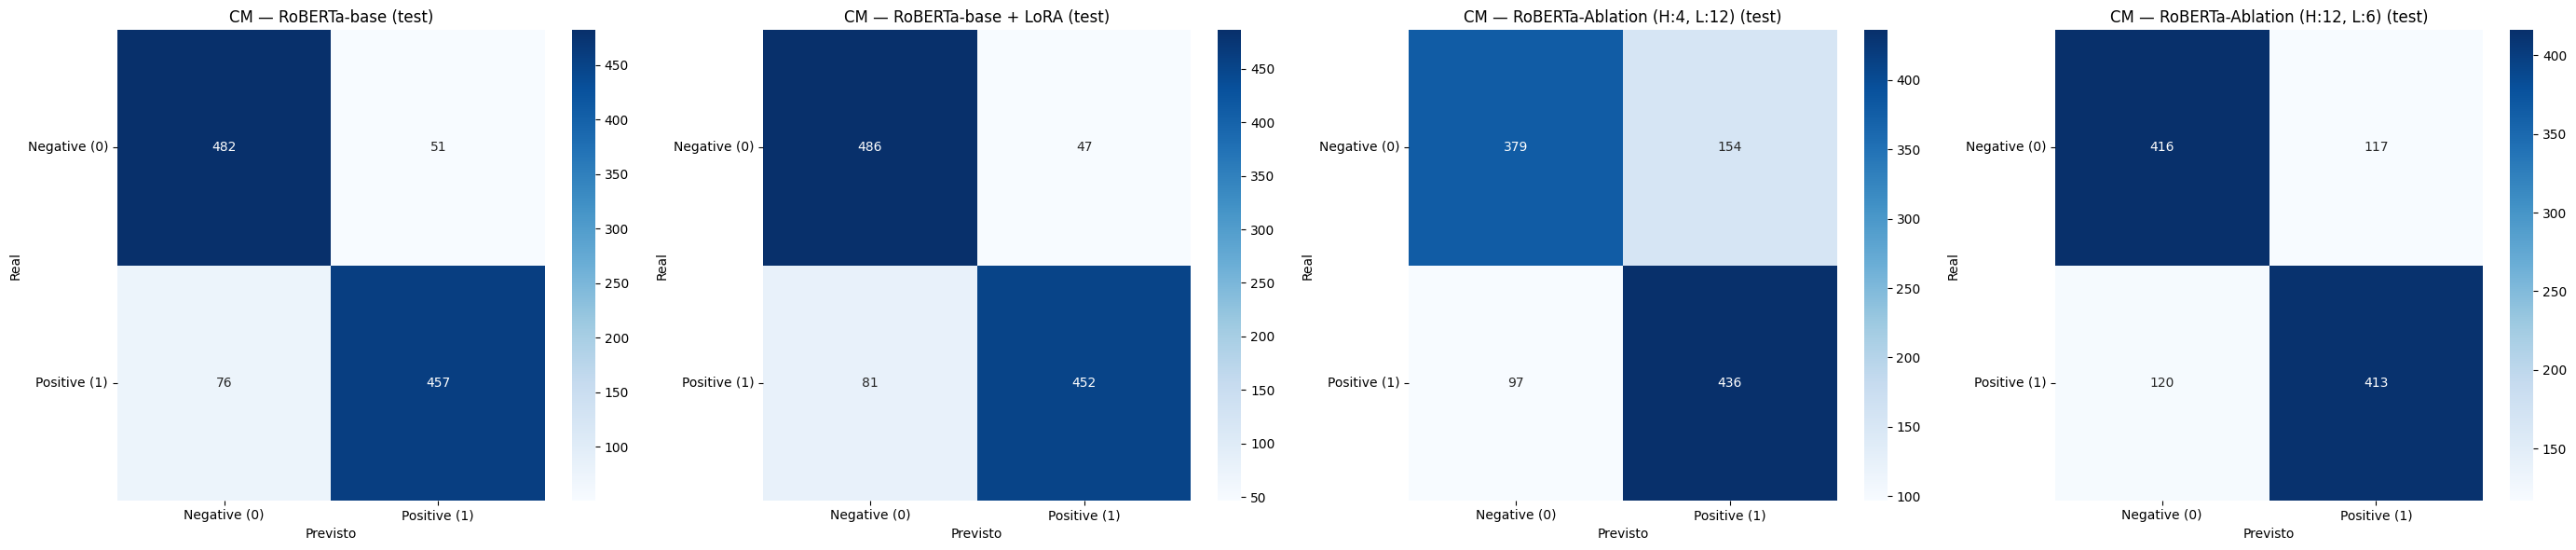

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
# No need to import AutoConfig or AutoModelForSequenceClassification here anymore
# as we will use the pre-computed predictions

def plot_confusion_matrix_styled(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Previsto')
    ax.set_ylabel('Real')
    ax.set_xticklabels(['Negative (0)', 'Positive (1)'])
    ax.set_yticklabels(['Negative (0)', 'Positive (1)'], rotation=0)

# Get predictions for RoBERTa-base
base_preds_output = base_trainer.predict(tok_ds["test"])
y_pred_base = np.argmax(base_preds_output.predictions, axis=1)
y_true_base = base_preds_output.label_ids

# Get predictions for RoBERTa-base + LoRA
lora_preds_output = lora_trainer.predict(tok_ds["test"])
y_pred_lora = np.argmax(lora_preds_output.predictions, axis=1)
y_true_lora = lora_preds_output.label_ids

# Use the globally available y_true_ablated_H4L12, y_pred_ablated_H4L12,
# y_true_ablated_H12L6 and y_pred_ablated_H12L6

# Plot confusion matrices
fig, axes = plt.subplots(1, 4, figsize=(28, 6)) # Aumentar o número de subplots para 4

plot_confusion_matrix_styled(y_true_base, y_pred_base, 'CM — RoBERTa-base (test)', axes[0])
plot_confusion_matrix_styled(y_true_lora, y_pred_lora, 'CM — RoBERTa-base + LoRA (test)', axes[1])
plot_confusion_matrix_styled(y_true_ablated_H4L12, y_pred_ablated_H4L12, 'CM — RoBERTa-Ablation (H:4, L:12) (test)', axes[2]) # Adicionar o primeiro modelo ablacionado
plot_confusion_matrix_styled(y_true_ablated_H12L6, y_pred_ablated_H12L6, 'CM — RoBERTa-Ablation (H:12, L:6) (test)', axes[3]) # Adicionar o segundo modelo ablacionado

plt.tight_layout()
plt.show()

### Carregar e obter previsões para o Modelo RoBERTa-Ablation (H:12, L:6)

Vamos carregar um dos modelos ablacionados que já foi treinado e salvo. Escolheremos a ablação com `num_attention_heads=12` e `num_hidden_layers=6`, pois ela apresentou um bom desempenho nos resultados da ablação.

### Tabela classificatória entre modelos


In [26]:
label_map = {0: "negativo", 1: "positivo"}

n_samples = 10  # Número de amostras para exibir na tabela
rng = np.random.default_rng(SEEDS[0]) # Usando a primeira seed configurada globalmente
indices = rng.choice(len(tok_ds["test"]), size=n_samples, replace=False)

# Certifique-se de que as previsões e rótulos verdadeiros estão disponíveis
# y_true_base e y_pred_base já vêm da avaliação do base_trainer
# y_true_lora e y_pred_lora já vêm da avaliação do lora_trainer
# y_true_ablated_H4L12 e y_pred_ablated_H4L12 e y_true_ablated_H12L6 e y_pred_ablated_H12L6
# agora vêm da avaliação dos modelos ablacionados

comparison_rows = []
for i in indices:
    text_review = tok_ds["test"]["text"][int(i)]
    true_label = label_map[int(y_true_base[i])] # True labels are the same for all
    predicted_base = label_map[int(y_pred_base[i])]
    predicted_lora = label_map[int(y_pred_lora[i])]
    predicted_ablated_H4L12 = label_map[int(y_pred_ablated_H4L12[i])] # Previsão do modelo ablacionado H4L12
    predicted_ablated_H12L6 = label_map[int(y_pred_ablated_H12L6[i])] # Previsão do modelo ablacionado H12L6

    comparison_rows.append({
        "texto": text_review,
        "verdadeiro": true_label,
        "previsto (RoBERTa-base)": predicted_base,
        "previsto (RoBERTa-base + LoRA)": predicted_lora,
        "previsto (RoBERTa-Ablation H:4, L:12)": predicted_ablated_H4L12, # Adicionar o modelo ablacionado H4L12
        "previsto (RoBERTa-Ablation H:12, L:6)": predicted_ablated_H12L6, # Adicionar o modelo ablacionado H12L6
    })

df_comparison = pd.DataFrame(comparison_rows)
display(df_comparison)

,texto,verdadeiro,previsto (RoBERTa-base),previsto (RoBERTa-base + LoRA),"previsto (RoBERTa-Ablation H:4, L:12)","previsto (RoBERTa-Ablation H:12, L:6)"
0,some of the most inventive silliness you are l...,positivo,positivo,positivo,positivo,positivo
1,nothing but an episode of smackdown ! in perio...,negativo,negativo,negativo,negativo,negativo
2,"everyone's insecure in lovely and amazing , a ...",positivo,positivo,positivo,positivo,positivo
3,forages for audience sympathy like a temperame...,negativo,negativo,negativo,negativo,negativo
4,a compelling story of musical passion against ...,positivo,positivo,positivo,positivo,positivo
5,it's a very valuable film . . .,positivo,positivo,positivo,positivo,positivo
6,routine and rather silly .,negativo,negativo,negativo,positivo,negativo
7,"symbolically , warm water under a red bridge i...",positivo,positivo,positivo,positivo,positivo
8,a small gem from belgium .,positivo,positivo,positivo,positivo,positivo
9,chen films the resolutely downbeat smokers onl...,negativo,negativo,negativo,negativo,positivo
